# Loan Approval Predictions
## Kaggle Competition

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
import h2o

## Part 1: Data Preprocessing

In [5]:
df = pd.read_csv('playground-series-s4e10/train.csv', index_col='id')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [7]:
X = df.drop('loan_status', axis=1)
y = df.loan_status

In [93]:
df.loan_status.mean()

0.14238212976383324

### One-Hot Encoding
We one-hot encode categorical variables

In [9]:
"""
Cell generated by Data Wrangler.
"""

def clean_data(X):
    # One-hot encode column: 'person_home_ownership'
    insert_loc = X.columns.get_loc('person_home_ownership')
    X = pd.concat([X.iloc[:,:insert_loc], pd.get_dummies(X.loc[:, ['person_home_ownership']]), X.iloc[:,insert_loc+1:]], axis=1)
    # One-hot encode column: 'loan_intent'
    insert_loc = X.columns.get_loc('loan_intent')
    X = pd.concat([X.iloc[:,:insert_loc], pd.get_dummies(X.loc[:, ['loan_intent']]), X.iloc[:,insert_loc+1:]], axis=1)
    # One-hot encode column: 'cb_person_default_on_file'
    insert_loc = X.columns.get_loc('cb_person_default_on_file')
    X = pd.concat([X.iloc[:,:insert_loc], pd.get_dummies(X.loc[:, ['cb_person_default_on_file']]), X.iloc[:,insert_loc+1:]], axis=1)
    # Change column type to int32 for column: 'cb_person_default_on_file_Y'
    X = X.astype({'cb_person_default_on_file_Y': 'int32'})
    # Drop column: 'cb_person_default_on_file_N'
    X = X.drop(columns=['cb_person_default_on_file_N'])
    # Change column type to int32 for column: 'person_home_ownership_MORTGAGE'
    X = X.astype({'person_home_ownership_MORTGAGE': 'int32'})
    # Change column type to int32 for columns: 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT'
    X = X.astype({'person_home_ownership_OTHER': 'int32', 'person_home_ownership_OWN': 'int32', 'person_home_ownership_RENT': 'int32'})
    # Change column type to int32 for columns: 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION' and 4 other columns
    X = X.astype({'loan_intent_DEBTCONSOLIDATION': 'int32', 'loan_intent_EDUCATION': 'int32', 'loan_intent_HOMEIMPROVEMENT': 'int32', 'loan_intent_MEDICAL': 'int32', 'loan_intent_PERSONAL': 'int32', 'loan_intent_VENTURE': 'int32'})
    return X

X_clean = clean_data(X.copy())
X_clean.head()

,person_age,person_income,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,person_emp_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file_Y,cb_person_cred_hist_length
id,,,,,,,,,,,,,,,,,,,
0,37,35000,0,0,0,1,0.0,0,1,0,0,0,0,B,6000,11.49,0.17,0,14
1,22,56000,0,0,1,0,6.0,0,0,0,1,0,0,C,4000,13.35,0.07,0,2
2,29,28800,0,0,1,0,8.0,0,0,0,0,1,0,A,6000,8.90,0.21,0,10
3,30,70000,0,0,0,1,14.0,0,0,0,0,0,1,B,12000,11.11,0.17,0,5
4,22,60000,0,0,0,1,2.0,0,0,0,1,0,0,A,6000,6.92,0.10,0,3


Encode loan_grade as an ordinal variable

In [13]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(categories=[['G','F','E','D','C','B','A']])
X_clean['loan_grade'] = encoder.fit_transform(X_clean[['loan_grade']])
X_clean.head()

,person_age,person_income,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,person_emp_length,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file_Y,cb_person_cred_hist_length
id,,,,,,,,,,,,,,,,,,,
0,37,35000,0,0,0,1,0.0,0,1,0,0,0,0,5.0,6000,11.49,0.17,0,14
1,22,56000,0,0,1,0,6.0,0,0,0,1,0,0,4.0,4000,13.35,0.07,0,2
2,29,28800,0,0,1,0,8.0,0,0,0,0,1,0,6.0,6000,8.90,0.21,0,10
3,30,70000,0,0,0,1,14.0,0,0,0,0,0,1,5.0,12000,11.11,0.17,0,5
4,22,60000,0,0,0,1,2.0,0,0,0,1,0,0,6.0,6000,6.92,0.10,0,3


### Scale Data
Using a MinMaxScaler, we are going to normalise the data.

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_clean)


# Part 2: Feature Selection

In [66]:
from sklearn.feature_selection import mutual_info_classif
feature_names = X_clean.columns
mutual_info = mutual_info_classif(X_scaled, y)
mutual_info_df = pd.concat([pd.Series(feature_names), pd.Series(mutual_info)], axis=1)
mutual_info_df.columns = ['feature', 'mutual_info']
mutual_info_df

,feature,mutual_info
0,person_age,0.003790
1,person_income,0.097576
2,person_home_ownership_MORTGAGE,0.027504
3,person_home_ownership_OTHER,0.000000
4,person_home_ownership_OWN,0.004527
5,person_home_ownership_RENT,0.040134
6,person_emp_length,0.009226
7,loan_intent_DEBTCONSOLIDATION,0.000343
8,loan_intent_EDUCATION,0.001242
9,loan_intent_HOMEIMPROVEMENT,0.000000


In [67]:
mutual_info_df.sort_values(by='mutual_info',ascending=False)

,feature,mutual_info
1,person_income,0.097576
15,loan_int_rate,0.084824
16,loan_percent_income,0.080649
13,loan_grade,0.079138
5,person_home_ownership_RENT,0.040134
2,person_home_ownership_MORTGAGE,0.027504
17,cb_person_default_on_file_Y,0.018085
14,loan_amnt,0.016877
6,person_emp_length,0.009226
4,person_home_ownership_OWN,0.004527


In [91]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y)

## Part 3: Sklearn Models
### Random Forest

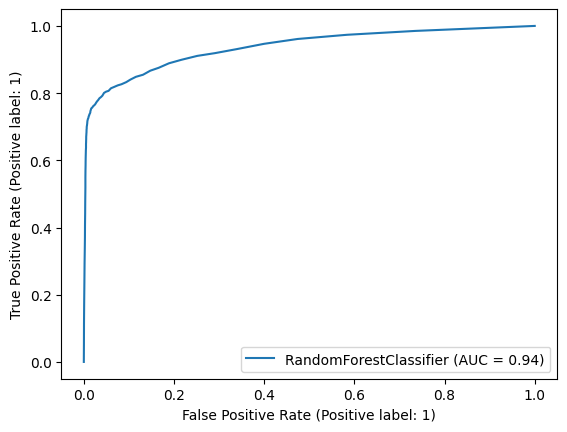

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
roc = RocCurveDisplay.from_estimator(rfc, X_valid, y_valid)


## XGBoost

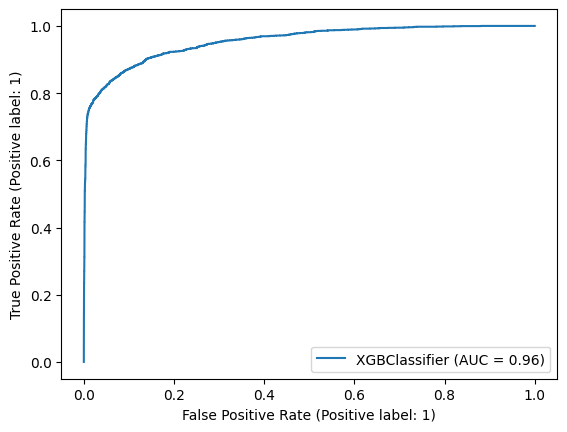

In [42]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
roc = RocCurveDisplay.from_estimator(xgb, X_valid, y_valid)

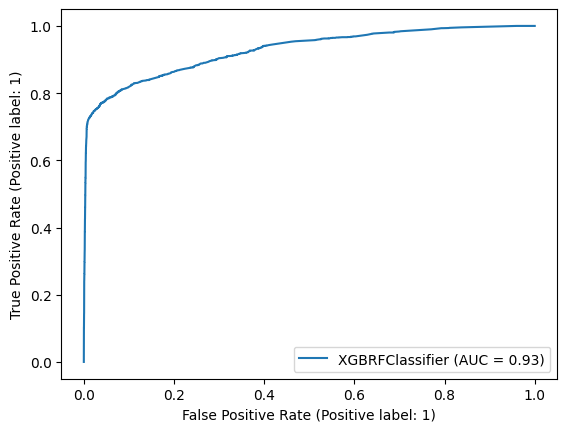

In [44]:
from xgboost import XGBRFClassifier
xgbrf = XGBRFClassifier()
xgbrf.fit(X_train, y_train)
roc = RocCurveDisplay.from_estimator(xgbrf, X_valid, y_valid)

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np

# Create different XGBoost configurations
xgb_configs = {
    'simple': {
        'max_depth': 3,
        'learning_rate': 0.1,
        'n_estimators': 100
    },
    'complex': {
        'max_depth': 8,
        'learning_rate': 0.1,
        'n_estimators': 200
    },
    'very_complex': {
        'max_depth': 12,
        'learning_rate': 0.05,
        'n_estimators': 300
    }
}

# Test different PCA components with each configuration
def test_pca_components(X, y, n_components_range=[0.7, 0.8, 0.9, 0.95]):
    results = {}
    
    for config_name, xgb_params in xgb_configs.items():
        results[config_name] = []
        
        for n_comp in n_components_range:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp)),
                ('xgb', XGBClassifier(**xgb_params))
            ])
            
            # Cross validate
            scores = cross_val_score(pipeline, X, y, cv=5)
            
            results[config_name].append({
                'n_components': n_comp,
                'mean_score': scores.mean(),
                'std_score': scores.std()
            })
            
    return results

# You could also do a joint search:
def joint_parameter_search(X, y):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('xgb', XGBClassifier())
    ])
    
    param_grid = {
        'pca__n_components': [0.7, 0.8, 0.9, 0.95],
        'xgb__max_depth': [3, 6, 9],
        'xgb__learning_rate': [0.01, 0.1],
        'xgb__n_estimators': [100, 200]
    }
    
    search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    
    search.fit(X, y)
    return search

# Analyze relationships between parameters
def analyze_parameter_relationships(search_results):
    """
    Analyze how optimal PCA components vary with XGBoost parameters
    """
    results_df = pd.DataFrame(search_results.cv_results_)
    
    # Group by XGBoost parameters and find best PCA components
    parameter_relationships = []
    
    for max_depth in results_df['param_xgb__max_depth'].unique():
        for lr in results_df['param_xgb__learning_rate'].unique():
            mask = (results_df['param_xgb__max_depth'] == max_depth) & \
                   (results_df['param_xgb__learning_rate'] == lr)
                   
            subset = results_df[mask]
            best_idx = subset['mean_test_score'].idxmax()
            
            parameter_relationships.append({
                'max_depth': max_depth,
                'learning_rate': lr,
                'best_n_components': results_df.loc[best_idx, 'param_pca__n_components'],
                'score': results_df.loc[best_idx, 'mean_test_score']
            })
    
    return pd.DataFrame(parameter_relationships)

In [71]:
search = joint_parameter_search(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=200; total time=   0.3s
[CV] END pca__n_components=0.7, xgb__learning_rate=0.01, xgb__ma

In [76]:
print(analyze_parameter_relationships(search))

   max_depth  learning_rate  best_n_components     score
0          3           0.01               0.95  0.892435
1          3           0.10               0.95  0.917037
2          6           0.01               0.95  0.912917
3          6           0.10               0.95  0.920301
4          9           0.01               0.95  0.918279
5          9           0.10               0.95  0.919863


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    ('pca', PCA(n_components=0.95)),
    ()
)

## Tuning the models

In [53]:
# XGB
model = XGBClassifier()
space_xgb=dict()
space_xgb['n_estimators'] = [10, 50, 75, 100, 200, 500, 750, 1000]
space_xgb['max_depth'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
space_xgb['learning_rate'] = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
space_xgb['subsample'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

search = RandomizedSearchCV(model, space_xgb, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3, n_iter=100)
results_xgb = search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV 2/5] END learning_rate=0.25, max_depth=60, n_estimators=50, subsample=0.8;, score=0.939 total time=   0.4s
[CV 1/5] END learning_rate=0.25, max_depth=60, n_estimators=50, subsample=0.8;, score=0.940 total time=   0.4s
[CV 4/5] END learning_rate=0.25, max_depth=60, n_estimators=50, subsample=0.8;, score=0.945 total time=   0.4s
[CV 5/5] END learning_rate=0.25, max_depth=60, n_estimators=50, subsample=0.8;, score=0.942 total time=   0.4s
[CV 3/5] END learning_rate=0.25, max_depth=60, n_estimators=50, subsample=0.8;, score=0.947 total time=   0.5s
[CV 2/5] END learning_rate=0.15, max_depth=80, n_estimators=75, subsample=0.9;, score=0.938 total time=   0.7s
[CV 1/5] END learning_rate=0.15, max_depth=80, n_estimators=75, subsample=0.9;, score=0.945 total time=   0.7s
[CV 4/5] END learning_rate=0.15, max_depth=80, n_estimators=75, subsample=0.9;, score=0.947 total time=   0.7s
[CV 3/5] END learning_rate=0.15, max_depth=80, n_estimators=75, subsample=0.9;, score=0.948 total time=   0.7s
[

In [54]:
print('XGB Best Score: %s' % results_xgb.best_score_)
print('XGB Best Hyperparameters: %s' % results_xgb.best_params_)

XGB Best Score: 0.9522716556244761
XGB Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': None, 'learning_rate': 0.1}


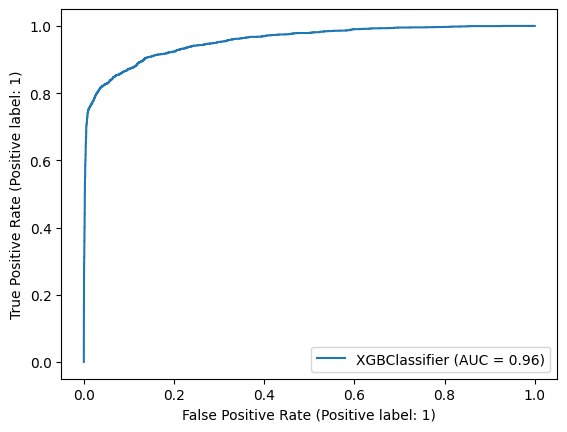

In [55]:
xgb = results_xgb.best_estimator_
roc = RocCurveDisplay.from_estimator(results_xgb.best_estimator_, X_valid, y_valid)

In [95]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
import numpy as np

def create_search_space(problem_type='default'):
    """
    Create a comprehensive search space for XGBClassifier hyperparameter tuning.
    
    Args:
        problem_type: 'default', 'large_dataset', or 'small_dataset'
        
    Returns:
        dict: Parameter search space
    """
    # Core parameters that control model complexity
    search_space = {
        # Tree-specific parameters
        'max_depth': randint(3, 12),          # Depth of trees (avoid overfitting)
        'min_child_weight': randint(1, 7),    # Min sum of instance weight in child
        'gamma': uniform(0, 0.5),             # Min loss reduction for split
        
        # Randomization parameters
        'subsample': uniform(0.6, 0.4),       # Sample ratio of training instances
        'colsample_bytree': uniform(0.6, 0.4),# Feature fraction for each tree
        'colsample_bylevel': uniform(0.6, 0.4),# Feature fraction for each level
        'colsample_bynode': uniform(0.6, 0.4), # Feature fraction for each split
        
        # Learning rate and number of estimators
        'learning_rate': uniform(0.01, 0.29),  # Smaller means more robust
        'n_estimators': randint(100, 1000),    # Number of trees
        
        # Regularization parameters
        'reg_alpha': uniform(0, 2),            # L1 regularization
        'reg_lambda': uniform(0, 2),           # L2 regularization
        
        # Tree growth parameters
        'max_leaves': randint(0, 8),           # Max number of leaves in trees
        'grow_policy': ['depthwise', 'lossguide'], # How to grow trees
    }
    
    # Adjust ranges based on problem type
    if problem_type == 'large_dataset':
        search_space.update({
            'max_depth': randint(3, 8),        # Shallower trees
            'n_estimators': randint(100, 500), # Fewer trees
            'learning_rate': uniform(0.1, 0.2), # Faster learning
            'grow_policy': ['lossguide'],      # More efficient growth
            'tree_method': ['hist'],           # Faster histogram-based approach
        })
    elif problem_type == 'small_dataset':
        search_space.update({
            'max_depth': randint(3, 15),       # Allow deeper trees
            'n_estimators': randint(200, 2000),# More trees possible
            'learning_rate': uniform(0.01, 0.19),# Slower learning
            'min_child_weight': randint(1, 5), # More granular splits
            'subsample': uniform(0.8, 0.2),    # Use more of the data
        })
    
    return search_space

def create_tuning_pipeline(X, y, search_space, n_iter=100, cv=5, scoring='roc_auc', random_state=42):
    """
    Create and configure the hyperparameter tuning pipeline.
    
    Args:
        X: Feature matrix
        y: Target vector
        search_space: Parameter search space
        n_iter: Number of random combinations to try
        cv: Number of cross-validation folds
        scoring: Metric to optimize
        random_state: Random seed
        
    Returns:
        RandomizedSearchCV: Configured search object
    """
    # Base model configuration
    model = XGBClassifier(
        objective='binary:logistic',  # Change for multi-class
        tree_method='auto',
        random_state=random_state,
        scale_pos_weight=6,
        n_jobs=-1  # Use all cores
    )
    
    # Cross-validation strategy
    cv_strategy = KFold(
        n_splits=cv,
        shuffle=True,
        random_state=random_state
    )
    
    # Configure the random search
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=search_space,
        n_iter=n_iter,
        cv=cv_strategy,
        scoring=scoring,
        random_state=random_state,
        n_jobs=-1,
        verbose=3,
        return_train_score=True
    )
    
    return search

def analyze_search_results(search):
    """
    Analyze and print the results of hyperparameter tuning.
    
    Args:
        search: Fitted RandomizedSearchCV object
    """
    # Best parameters and score
    print("Best parameters found:")
    for param, value in search.best_params_.items():
        print(f"{param}: {value}")
    print(f"\nBest cross-validation score: {search.best_score_:.4f}")
    
    # Parameter importance analysis
    param_importances = {}
    for param in search.param_distributions.keys():
        scores = []
        values = []
        for params, score in zip(search.cv_results_['params'], 
                               search.cv_results_['mean_test_score']):
            scores.append(score)
            values.append(params[param])
        
        # Calculate correlation between parameter value and score
        if isinstance(values[0], (int, float)):
            correlation = np.corrcoef(values, scores)[0,1]
            param_importances[param] = abs(correlation)
    
    print("\nParameter importance (absolute correlation with score):")
    for param, importance in sorted(param_importances.items(), 
                                  key=lambda x: x[1], reverse=True):
        if not np.isnan(importance):
            print(f"{param}: {importance:.4f}")

# Example usage:

# Create search space based on your dataset size
search_space = create_search_space('small_dataset')  # or 'large_dataset' or 'small_dataset'

# Create and run the tuning pipeline
search = create_tuning_pipeline(X_scaled, y, search_space)
search.fit(X_scaled, y)

# Analyze results
analyze_search_results(search)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 4/5] END colsample_bylevel=0.749816047538945, colsample_bynode=0.9802857225639665, colsample_bytree=0.892797576724562, gamma=0.2993292420985183, grow_policy=depthwise, learning_rate=0.09470822304218231, max_depth=9, max_leaves=2, min_child_weight=3, n_estimators=287, reg_alpha=0.6674172222780437, reg_lambda=0.28573363584388156, subsample=0.9301776945897706;, score=(train=0.921, test=0.925) total time=   0.4s
[CV 5/5] END colsample_bylevel=0.749816047538945, colsample_bynode=0.9802857225639665, colsample_bytree=0.892797576724562, gamma=0.2993292420985183, grow_policy=depthwise, learning_rate=0.09470822304218231, max_depth=9, max_leaves=2, min_child_weight=3, n_estimators=287, reg_alpha=0.6674172222780437, reg_lambda=0.28573363584388156, subsample=0.9301776945897706;, score=(train=0.924, test=0.913) total time=   0.4s
[CV 2/5] END colsample_bylevel=0.749816047538945, colsample_bynode=0.9802857225639665, colsample_bytree=0

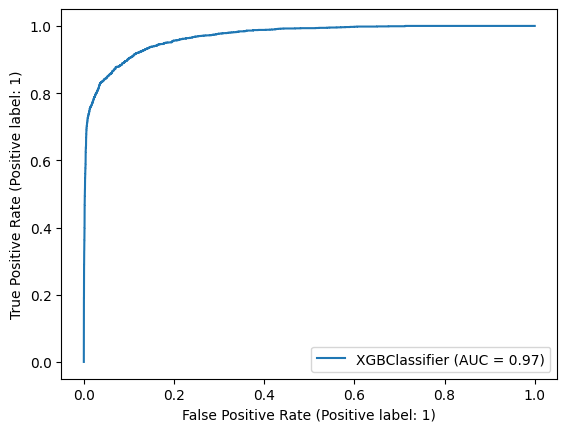

In [96]:
roc = RocCurveDisplay.from_estimator(search.best_estimator_, X_valid, y_valid)

# Part 4: Testing the Model

In [88]:
df_test = pd.read_csv('playground-series-s4e10/test.csv', index_col='id')
df_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [89]:
X_test = clean_data(df_test.copy())
X_test['loan_grade'] = encoder.transform(X_test[['loan_grade']])
X_test_scaled = scaler.transform(X_test)

In [97]:
y_preds = search.best_estimator_.predict(X_test_scaled)
df_test['loan_status'] = y_preds
df_test['loan_status']

id
58645    1
58646    0
58647    1
58648    0
58649    0
        ..
97738    0
97739    0
97740    0
97741    1
97742    1
Name: loan_status, Length: 39098, dtype: int64

In [98]:
df_test['loan_status'].to_csv('submission.csv')